# SQL Injection Detection using Machine Learning

In [1]:
%pip install seaborn
%pip install nltk
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# importing required libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

## Reading sql data file 

In [3]:
#df = pd.read_csv(r'C:\Users\Snehal Thakur\PycharmProjects\SQLInjectionML\dataset\sqlCleaned.csv', encoding = 'utf-16') # Read the dataset.
df = pd.read_csv(r'C:\Users\Snehal Thakur\PycharmProjects\SQLInjectionML\dataset\sql_30k.csv') # Read the dataset.
df.head(10)

,Sentence,Label,Unnamed: 2,Unnamed: 3
0,""" or pg_sleep ( __TIME__ ) --""",1,NaN,NaN
1,create user name identified by pass123 tempora...,1,NaN,NaN
2,AND 1 = utl_inaddr.get_host_address ( ...,1,NaN,NaN
3,select * from users where id = '1' or @ @1 ...,1,NaN,NaN
4,"select * from users where id = 1 or 1#"" ( ...",1,NaN,NaN
5,select name from syscolumns where id = ...,1,NaN,NaN
6,select * from users where id = 1 +$+ or 1 =...,1,NaN,NaN
7,"1; ( load_file ( char ( 47,101,116,99,47...",1,NaN,NaN
8,select * from users where id = '1' or ||/1 ...,1,NaN,NaN
9,select * from users where id = '1' or \.<\ ...,1,NaN,NaN


## Shape of Dataframe

In [4]:
df.shape

(30909, 4)

In [5]:
df.drop(["Unnamed: 2","Unnamed: 3"], axis=1, inplace=True)

In [6]:
df

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --""",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
...,...,...
30904,DELETE FROM door WHERE grow = 'small',0
30905,DELETE FROM tomorrow,0
30906,SELECT wide ( s ) FROM west,0
30907,SELECT * FROM ( SELECT slide FROM breath ),0


## Dataframe column information 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30909 entries, 0 to 30908
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  30897 non-null  object
 1   Label     30909 non-null  object
dtypes: object(2)
memory usage: 483.1+ KB


## Describe Dataframe 

In [8]:
df.describe(include="all")

,Sentence,Label
count,30897,30909
unique,30869,14
top,#NAME?,0
freq,8,19537


## Describe Label column 

In [9]:
df['Label'].describe()

count     30909
unique       14
top           0
freq      19537
Name: Label, dtype: object

## Check null values 

In [10]:
df.isna().sum()

Sentence    12
Label        0
dtype: int64

## Drop null values 

In [11]:
df.dropna(inplace=True)

## Check null values after dropping null values 

In [12]:
df.isna().sum()

Sentence    0
Label       0
dtype: int64

##  Count values where Label is 1 

In [13]:
df[df['Label'] == 1].count() # Count how much label are 1.

Sentence    0
Label       0
dtype: int64

##  Count values where Label is 0

In [14]:
df[df['Label'] == 0].count() # Count how much label are 0.

Sentence    0
Label       0
dtype: int64

## Label value counts

In [15]:
df['Label'].value_counts()

0    19537
1    11360
Name: Label, dtype: int64

In [16]:
df['Label'] = df['Label'].apply(pd.to_numeric,errors='ignore')

In [17]:
df['Label'].value_counts()

0    19537
1    11360
Name: Label, dtype: int64

## Plot label counts 

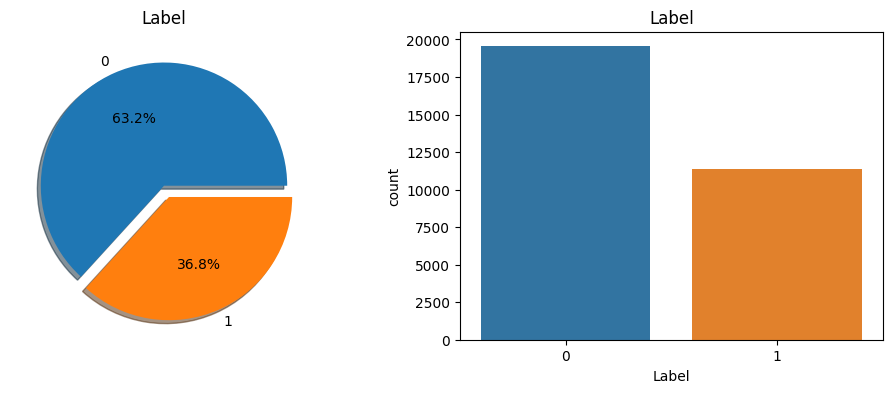

In [18]:
f,ax=plt.subplots(1,2,figsize=(12,4))
df['Label'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)


ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot(x=df["Label"],ax=ax[1])
ax[1].set_title('Label')
plt.show()

# Approach 1. Count Vectorizer

##  CountVectorizer - Convert a collection of text documents to a matrix of token counts

In [19]:
X = df['Sentence']
y = df['Label']
# CountVectorizer - Convert a collection of text documents to a matrix of token counts
count_vectorizer = CountVectorizer(min_df = 2, max_df = 0.8, stop_words = stopwords.words('english'))
X = count_vectorizer.fit_transform(X.values.astype('U')).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [20]:
count_vectorizer.get_feature_names()

C:\Users\Public\DataScience\envs\sqlinjection\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00',
 '000001',
 '000003',
 '000004',
 '000023',
 '01',
 '015',
 '03',
 '06',
 '07',
 '08',
 '09',
 '0x28',
 '0x2e',
 '0x4b774c75',
 '0x4c4d6142',
 '0x52515a50',
 '0x544d5a4c',
 '0x5c',
 '0x694a4745',
 '0x6d457153',
 '0x7171706a71',
 '0x717a767a71',
 '0x72747341',
 '0x730065006c00650063007400200040004000760065007200730069006f006e00',
 '0x73656c65637420404076657273696f6e',
 '0x76555642',
 '0x77616974666f722064656c61792027303a303a31302700',
 '0x78',
 '10',
 '100',
 '1000',
 '10000000',
 '1001',
 '1002',
 '1004',
 '1005',
 '1007',
 '101',
 '1013',
 '1015',
 '102',
 '1020',
 '1022',
 '103',
 '1030',
 '1031',
 '1032',
 '1036',
 '104',
 '1040',
 '1043',
 '1044',
 '1045',
 '1047',
 '1048',
 '105',
 '1050',
 '1051',
 '1052',
 '1055',
 '1056',
 '106',
 '1064',
 '107',
 '1071',
 '1074',
 '1076',
 '1079',
 '108',
 '1082',
 '1083',
 '1084',
 '1085',
 '1087',
 '109',
 '1090',
 '1091',
 '1093',
 '1096',
 '10a',
 '10d',
 '10f',
 '10h',
 '11',
 '110',
 '1100',
 '1102',
 '1105',
 '1107',
 '111',
 '11

### Train-test split 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print("X_train.shape - ",X_train.shape)
print("y_train.shape -", y_train.shape)
print("X_test.shape -", X_test.shape)
print("y_test.shape -", y_test.shape)

X_train.shape -  (24717, 6578)
y_train.shape - (24717,)
X_test.shape - (6180, 6578)
y_test.shape - (6180,)


In [22]:
X_test[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## LogisticRegression Classifier 

In [23]:
lr_clf = LogisticRegression() 
lr_clf.fit(X_train, y_train) # training
y_pred = lr_clf.predict(X_test)
print(f"Accuracy of Logistic Regression on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of Logistic Regression on test set : {f1_score(y_pred, y_test)}")

Accuracy of Logistic Regression on test set : 0.941747572815534
F1 Score of Logistic Regression on test set : 0.915014164305949


### Classification Report of Logistic Regression 

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      3922
           1       0.98      0.86      0.92      2258

    accuracy                           0.94      6180
   macro avg       0.95      0.92      0.94      6180
weighted avg       0.94      0.94      0.94      6180



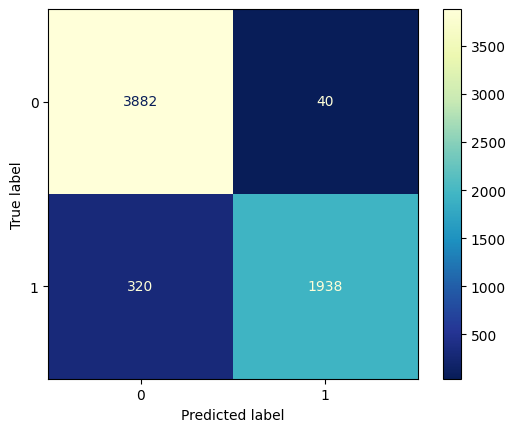

In [25]:
confmatrix = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(confmatrix, display_labels=["0", "1"])
cm.plot(cmap="YlGnBu_r")
plt.show()

### Saving the Logistic Regression model 

In [26]:
import joblib
  
  
# Save the model as a pickle in a file
joblib.dump(lr_clf, r'C:\Users\Snehal Thakur\PycharmProjects\SQLInjectionML\models\lr_clf.pkl')
  
# # Load the model from the file
# lr_clf_from_joblib = joblib.load('/models/lr_clf.pkl')
  
# # Use the loaded model to make predictions
# lr_clf_from_joblib.predict(X_test)

['C:\\Users\\Snehal Thakur\\PycharmProjects\\SQLInjectionML\\models\\lr_clf.pkl']

## RandomForestClassifier 

In [27]:
# create RandomForestClassifier model instance
rf_clf = RandomForestClassifier()
# fit RandomForestClassifier model
rf_clf.fit(X_train, y_train)
# make predictions
y_pred = rf_clf.predict(X_test)
print(f"Accuracy of Random Forest on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of Random Forest on test set : {f1_score(y_pred, y_test)}")

Accuracy of Random Forest on test set : 0.9320388349514563
F1 Score of Random Forest on test set : 0.9057027391109116


### Classification Report of RandomForestClassifier

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3922
           1       0.92      0.89      0.91      2258

    accuracy                           0.93      6180
   macro avg       0.93      0.92      0.93      6180
weighted avg       0.93      0.93      0.93      6180



### Confusion  matrix of RandomForest Classifier

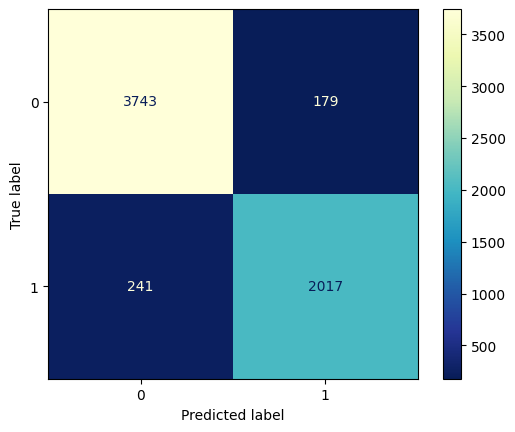

In [29]:
confmatrix = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(confmatrix, display_labels=["0", "1"])
cm.plot(cmap="YlGnBu_r")
plt.show()

### Saving the Random Forest Model 

In [30]:
import joblib
  
  
# Save the model as a pickle in a file
joblib.dump(rf_clf, r'C:\Users\Snehal Thakur\PycharmProjects\SQLInjectionML\models\rf_clf.pkl')
  
# # Load the model from the file
# rf_clf_from_joblib = joblib.load('/models/rf_clf.pkl')
  
# # Use the loaded model to make predictions
# rf_clf_from_joblib.predict(X_test)

['C:\\Users\\Snehal Thakur\\PycharmProjects\\SQLInjectionML\\models\\rf_clf.pkl']

## XGBoost Classifier 

In [31]:
# create XGBoost model instance
xgb_clf = XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.01, alpha = 10,objective='binary:logistic')
# fit XGBoost model
xgb_clf.fit(X, y)
# make predictions
y_pred = xgb_clf.predict(X_test)
print(f"Accuracy of XGBClassifier on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of XGBClassifier on test set : {f1_score(y_pred, y_test)}")

Accuracy of XGBClassifier on test set : 0.8493527508090615
F1 Score of XGBClassifier on test set : 0.7507362784471219


### Classification Report of XGBoost Classifier

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      3922
           1       0.95      0.62      0.75      2258

    accuracy                           0.85      6180
   macro avg       0.88      0.80      0.82      6180
weighted avg       0.87      0.85      0.84      6180



### Confusion Matrix of XGBoost Classifier

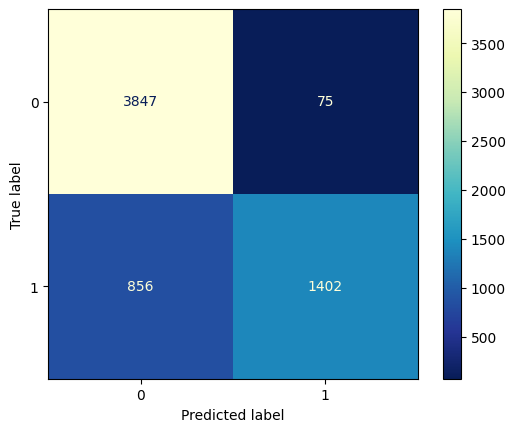

In [33]:
confmatrix = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(confmatrix, display_labels=["0", "1"])
cm.plot(cmap="YlGnBu_r")
plt.show()

### Saving the XGBoost Model 

In [34]:
import joblib
  
  
# Save the model as a pickle in a file
joblib.dump(xgb_clf, r'C:\Users\Snehal Thakur\PycharmProjects\SQLInjectionML\models\xgb_clf.pkl')
  
# # Load the model from the file
# xgb_clf_from_joblib = joblib.load('/models/xgb_clf.pkl')
  
# # Use the loaded model to make predictions
# xgb_clf_from_joblib.predict(X_test)

['C:\\Users\\Snehal Thakur\\PycharmProjects\\SQLInjectionML\\models\\xgb_clf.pkl']

## ExtraTreesClassifier 

In [35]:
# create ExtraTreesClassifier model instance
xtree_clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
# fit ExtraTreesClassifier model
xtree_clf.fit(X, y)
# make predictions
y_pred = xtree_clf.predict(X_test)
print(f"Accuracy of ExtraTreesClassifier on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of ExtraTreesClassifier on test set : {f1_score(y_pred, y_test)}")

Accuracy of ExtraTreesClassifier on test set : 0.9867313915857605
F1 Score of ExtraTreesClassifier on test set : 0.9816061013907582


### Classification Report of ExtraTreesClassifier

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3922
           1       0.99      0.97      0.98      2258

    accuracy                           0.99      6180
   macro avg       0.99      0.98      0.99      6180
weighted avg       0.99      0.99      0.99      6180



### Confusion Matrix of ExtraTreesClassifier

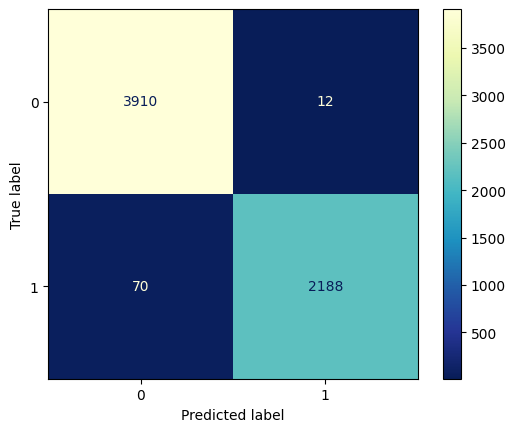

In [37]:
confmatrix = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(confmatrix, display_labels=["0", "1"])
cm.plot(cmap="YlGnBu_r")
plt.show()

### Saving the Extratree classifier model 

In [38]:
import joblib
  
  
# Save the model as a pickle in a file (Use your model dir path)
joblib.dump(xtree_clf, r'C:\Users\Snehal Thakur\PycharmProjects\SQLInjectionML\models\xtree_clf.pkl')
  
# # Load the model from the file
# xtree_clf_from_joblib = joblib.load('/models/xtree_clf.pkl')
  
# # Use the loaded model to make predictions
# xtree_clf_from_joblib.predict(X_test)

['C:\\Users\\Snehal Thakur\\PycharmProjects\\SQLInjectionML\\models\\xtree_clf.pkl']

# Approach 2. TF-IDF Vectorizer

## TfidfVectorizer - Convert a collection of raw documents to a matrix of TF-IDF features. 

In [39]:
# TfidfVectorizer - Convert a collection of raw documents to a matrix of TF-IDF features.# 

X = df['Sentence']
y = df['Label']

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X.values.astype('U')).toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
# feature names
tfidf_vectorizer.get_feature_names()

C:\Users\Public\DataScience\envs\sqlinjection\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00',
 '000001',
 '000003',
 '000004',
 '000023',
 '000045',
 '00033926r',
 '00041731d',
 '00207473j',
 '00505336a',
 '00699529f',
 '00783778f',
 '007tv',
 '00903443a',
 '00916150z',
 '01',
 '01062744y',
 '01449063v',
 '015',
 '01632755p',
 '01633578a',
 '017',
 '0199e',
 '02',
 '02048n3ad1',
 '02054707w',
 '02056001p',
 '02124892z',
 '02314635f',
 '02612e',
 '02624260y',
 '02650843r',
 '02877417w',
 '02879028a',
 '02906029w',
 '02_01',
 '02ap36o5473',
 '03',
 '03046730n',
 '03206041w',
 '03287e',
 '03291016s',
 '03307827j',
 '03331390r',
 '03344221k',
 '03482859s',
 '03621656f',
 '03770036z',
 '037r20n0do',
 '03996e',
 '03nte99era',
 '03t86i3',
 '041',
 '04146926a',
 '04422e',
 '04492457m',
 '04607227m',
 '04or2ativ1',
 '05',
 '05072293b',
 '0515e',
 '05636576n',
 '056cun95v08ac497',
 '05923e',
 '06',
 '06153e',
 '06226784v',
 '06314426y',
 '06327548h',
 '06363808f',
 '06434691g',
 '06673981w',
 '06918701w',
 '07',
 '07077546d',
 '07194416q',
 '07375030b',
 '07383536f',
 '07441681p',

### Train Test Split 

In [41]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size = 0.2)
print("X_train_tfidf.shape=", X_train_tfidf.shape)
print("y_train_tfidf.shape=", y_train_tfidf.shape)
print("X_test_tfidf.shape=", X_test_tfidf.shape)
print("y_test_tfidf.shape=", y_test_tfidf.shape)

X_train_tfidf.shape= (24717, 24736)
y_train_tfidf.shape= (24717,)
X_test_tfidf.shape= (6180, 24736)
y_test_tfidf.shape= (6180,)


## Logistic Regression 

In [42]:
lr_clf_tfidf = LogisticRegression()
lr_clf_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = lr_clf_tfidf.predict(X_test_tfidf)
print(f"Accuracy of Logistic Regression on test set : {accuracy_score(y_pred_tfidf, y_test_tfidf)}")
print(f"F1 Score of Logistic Regression on test set : {f1_score(y_pred_tfidf, y_test_tfidf)}")

Accuracy of Logistic Regression on test set : 0.9454692556634304
F1 Score of Logistic Regression on test set : 0.9215001164686699


###  Classification Report

In [43]:
print(classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3911
           1       0.98      0.87      0.92      2269

    accuracy                           0.95      6180
   macro avg       0.95      0.93      0.94      6180
weighted avg       0.95      0.95      0.94      6180



### Confusion Matrix 

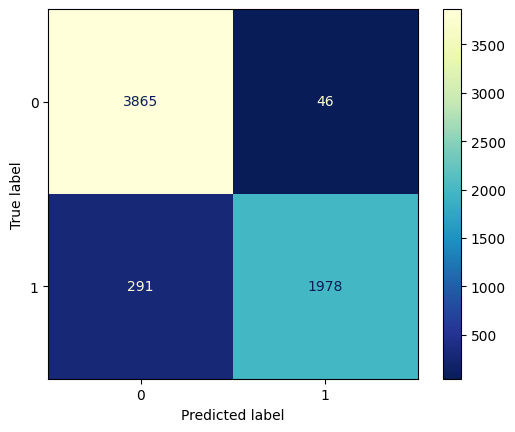

In [44]:
confmatrix = confusion_matrix(y_test_tfidf, y_pred_tfidf)
cm = ConfusionMatrixDisplay(confmatrix, display_labels=["0", "1"])
cm.plot(cmap="YlGnBu_r")
plt.show()

##  Random Forest Classifier

In [45]:
# create RandomForestClassifier model instance
rf_clf_tfidf = RandomForestClassifier()
# fit RandomForestClassifier model
rf_clf_tfidf.fit(X_train_tfidf, y_train_tfidf)
# make predictions
y_pred_tfidf = rf_clf_tfidf.predict(X_test_tfidf)
print(f"Accuracy of Random Forest on test set : {accuracy_score(y_pred_tfidf, y_test_tfidf)}")
print(f"F1 Score of Random Forest on test set : {f1_score(y_pred_tfidf, y_test_tfidf)}")

Accuracy of Random Forest on test set : 0.7938511326860841
F1 Score of Random Forest on test set : 0.7804205446397793


### Classification Report 

In [46]:
print(classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       1.00      0.68      0.81      3911
           1       0.64      1.00      0.78      2269

    accuracy                           0.79      6180
   macro avg       0.82      0.84      0.79      6180
weighted avg       0.87      0.79      0.80      6180



### Confusion Matrix 

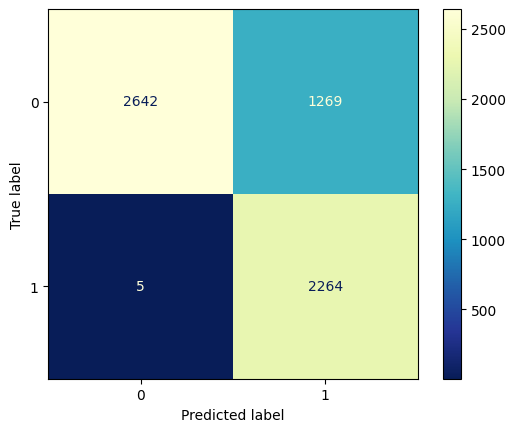

In [47]:
confmatrix = confusion_matrix(y_test_tfidf, y_pred_tfidf)
cm = ConfusionMatrixDisplay(confmatrix, display_labels=["0", "1"])
cm.plot(cmap="YlGnBu_r")
plt.show()

## XGBoost Classifier 

In [48]:
# create XGBoost model instance
xgb_clf_tfidf = XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.01, alpha = 10,objective='binary:logistic')
# fit XGBoost model
xgb_clf_tfidf.fit(X_train_tfidf, y_train_tfidf)
# make predictions
y_pred_tfidf = xgb_clf_tfidf.predict(X_test_tfidf)
print(f"Accuracy of XGBClassifier on test set : {accuracy_score(y_pred_tfidf, y_test_tfidf)}")
print(f"F1 Score of XGBClassifier on test set : {f1_score(y_pred_tfidf, y_test_tfidf)}")

Accuracy of XGBClassifier on test set : 0.976051779935275
F1 Score of XGBClassifier on test set : 0.9664246823956443


### Classification Report 

In [49]:
print(classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3911
           1       1.00      0.94      0.97      2269

    accuracy                           0.98      6180
   macro avg       0.98      0.97      0.97      6180
weighted avg       0.98      0.98      0.98      6180



### Confusion Matrix 

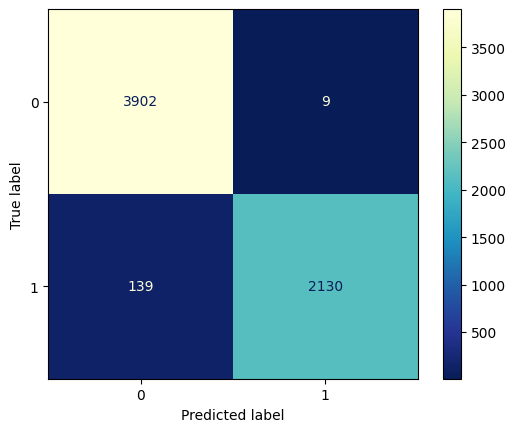

In [50]:
confmatrix = confusion_matrix(y_test_tfidf, y_pred_tfidf)
cm = ConfusionMatrixDisplay(confmatrix, display_labels=["0", "1"])
cm.plot(cmap="YlGnBu_r")
plt.show()

## Extratree Classifier 

In [51]:
# create ExtraTreesClassifier model instance
xtree_clf_tfidf = ExtraTreesClassifier(n_estimators=100, random_state=0)
# fit ExtraTreesClassifier model
xtree_clf_tfidf.fit(X_train_tfidf, y_train_tfidf)
# make predictions
y_pred_tfidf = xtree_clf_tfidf.predict(X_test_tfidf)
print(f"Accuracy of ExtraTreesClassifier on test set : {accuracy_score(y_pred_tfidf, y_test_tfidf)}")
print(f"F1 Score of ExtraTreesClassifier on test set : {f1_score(y_pred_tfidf, y_test_tfidf)}")

Accuracy of ExtraTreesClassifier on test set : 0.801294498381877
F1 Score of ExtraTreesClassifier on test set : 0.7865090403337969


### Classification Report 

In [52]:
print(classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       1.00      0.69      0.81      3911
           1       0.65      1.00      0.79      2269

    accuracy                           0.80      6180
   macro avg       0.82      0.84      0.80      6180
weighted avg       0.87      0.80      0.80      6180



### Confusion Matrix 

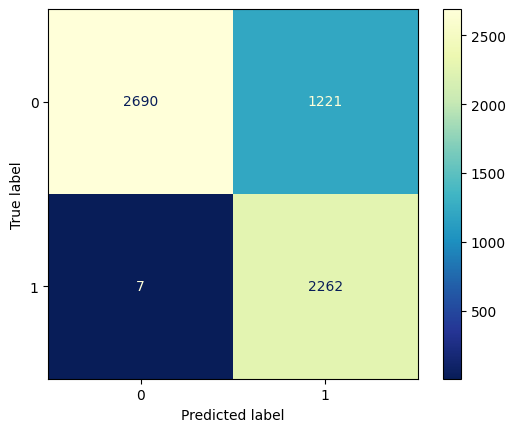

In [53]:
confmatrix = confusion_matrix(y_test_tfidf, y_pred_tfidf)
cm = ConfusionMatrixDisplay(confmatrix, display_labels=["0", "1"])
cm.plot(cmap="YlGnBu_r")
plt.show()

### Saving the Extratree model 

In [58]:
import joblib
  
  
# Save the model as a pickle in a file
joblib.dump(xtree_clf_tfidf, r'C:\Users\Snehal Thakur\PycharmProjects\SQLInjectionML\models\xtree_clf_tfidf.pkl')
  
# # Load the model from the file
# xtree_clf_from_joblib = joblib.load('/models/xtree_clf.pkl')
  
# # Use the loaded model to make predictions
# xtree_clf_from_joblib.predict(X_test)

['C:\\Users\\Snehal Thakur\\PycharmProjects\\SQLInjectionML\\models\\xtree_clf_tfidf.pkl']

### Testing of Extratree Classifier model on unknown data

In [55]:
text=input(" Enter your text for prediction ")

 Enter your text for prediction SELECT TOP 3 * FROM race


In [59]:
# print('Vectorized Input:')
v0 = tfidf_vectorizer.transform([text]).toarray()
# print(v0)
pred = xtree_clf_tfidf.predict(v0)
#print("Predicted Output = ",pred)
if pred[0]==0:
    print("It seems to be safe input")
else:
    print("ALERT :::: This can be SQL injection")

It seems to be safe input


### Inverse transform 

In [60]:
print('To the source:')
print(tfidf_vectorizer.inverse_transform(v0))

To the source:
[array(['from', 'race', 'select', 'top'], dtype='<U170')]
